# Title

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
from pprint import pprint
%matplotlib inline

In [2]:
# From https://github.com/naokishibuya/car-finding-lane-lines/blob/master/Finding%20Lane%20Lines%20on%20the%20Road.ipynb
def show_images(images, cols=2, cmap=None):
    rows = (len(images)+1)//cols
    
    plt.figure(figsize=(10,11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        cmap = "gray" if len(image.shape) == 2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

In [3]:
def grayscale(img):
    """Returns a gray image from RGB"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

## Camera Calibration
Cameras often have some distortion that will effect the perception of size and distance.
Therefore, the first step before using images for data is calibration to correct this distortion

In [4]:
calibration_images = [plt.imread(name) for name in glob.glob("camera_cal/*.jpg")]

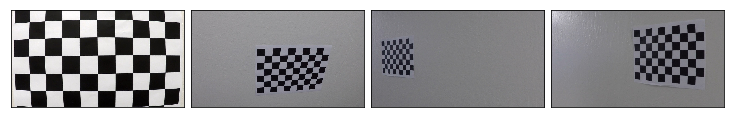

In [5]:
show_images(calibration_images[:4], cols=4)

In [6]:
def calibrate_camera(images):
    """Returns camera calibration metrics
    Arguments:
    images: A set of images using checkerboard calibration
    """
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    
    # True location in grid
    objpoints = []
    # Location of corners in checkerboard
    imgpoints = []
    
    for image in images:
        gray = grayscale(image)
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        # If checkboard is detected
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return ret, mtx, dist, rvecs, tvecs
    
ret, mtx, dist, rvecs, tvecs = calibrate_camera(calibration_images)

In [7]:
images = list(map(lambda image: cv2.undistort(image, mtx, dist, None, mtx), calibration_images))

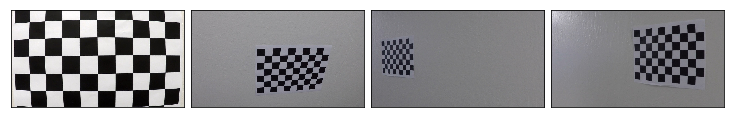

In [8]:
show_images(calibration_images[:4], cols=4)

## Pipeline

- Undistort

In [9]:
# Load in test images
test_images = [plt.imread(name) for name in glob.glob("test_images/*.jpg")]

### Undistort

In [10]:
# Undistorts all test images
test_images = list(map(lambda image: cv2.undistort(image, mtx, dist, None, mtx), test_images))

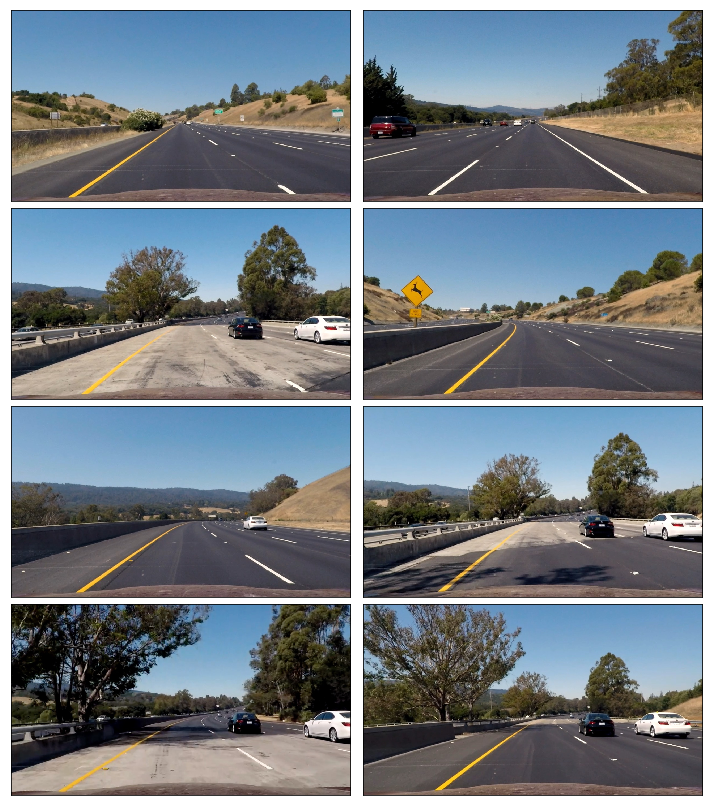

In [11]:
show_images(test_images) # Shows undistorted images

In [12]:
blur = [cv2.GaussianBlur(img, (5, 5), 0) for img in test_images]

### Threshold Selection

In [13]:
from functools import reduce
def apply_masks_and(img, masks):
    # Returns all masks "and" together
    mask = reduce((lambda x, y: cv2.bitwise_and(x, y)), masks)
    return cv2.bitwise_and(img, img, mask=mask)

def apply_masks_or(img, masks):
     # Returns all masks "or" together
    mask = reduce((lambda x, y: cv2.bitwise_or(x, y)), masks)
    return cv2.bitwise_or(img, img, mask=mask)

In [14]:
def hls_select(img, h=(0,255), l=(0,255), s=(0,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    thresholds = np.array([h, l, s], dtype=np.uint8).T
    binary_output = cv2.inRange(hls, thresholds[0], thresholds[1])
    return binary_output

In [15]:
def color_select(img, r=(0,255), g=(0,255), b=(0,255)):
    thresholds = np.array([r, g, b], dtype=np.uint8).T
    binary_output = cv2.inRange(img, thresholds[0], thresholds[1])
    return binary_output

In [16]:
def sobelx_select(img, thres=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    binary_output = cv2.inRange(scaled_sobelx, thres[0], thres[1])
    return binary_output

In [17]:
hls_selection = [hls_select(img, s=(150,255)) for img in blur]

In [18]:
color_selection = [color_select(img, b=(120,255)) for img in blur]

In [19]:
sobelx_selection = [sobelx_select(img, (20, 100)) for img in blur]

In [20]:
threshold = [apply_masks_or(img, [mask1, mask2]) for img, mask1, mask2 in zip(blur, sobelx_selection, hls_selection)]
threshold = [grayscale(img) for img in threshold]

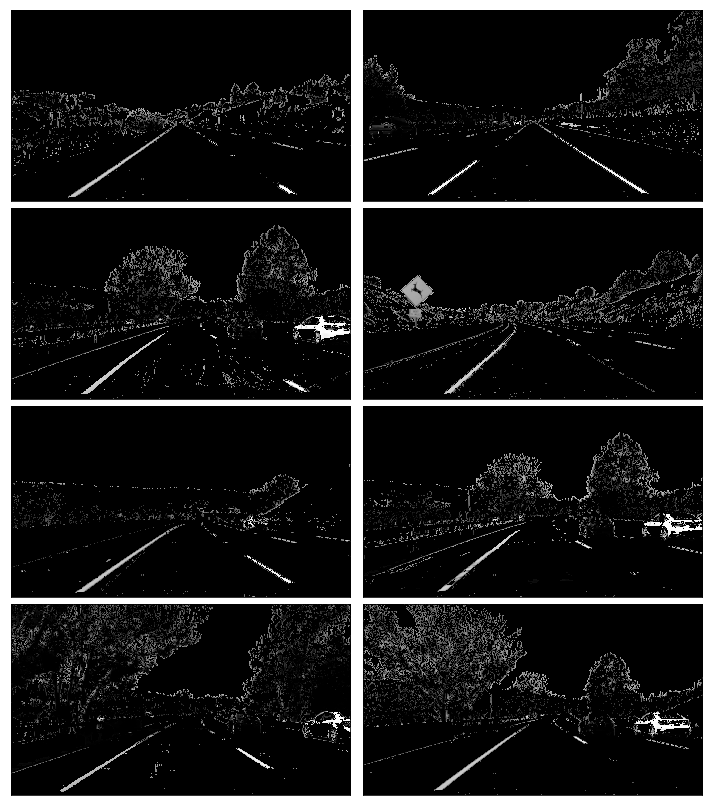

In [21]:
show_images(threshold, cmap="gray")

### Perspective Transform

In [22]:
def get_perspective_matrices(img):
    img_size = (img.shape[1], img.shape[0])
    # Offset of left/right sides
    offset = 300
    # Pixels of the image assumed to represent a straight line
    # Top-Left, Top-Right, Bottom-Left, Bottom-Right
    src = np.float32([[572,469],[713,469],[278,677],[1031,677]])
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset],
                                    [offset, img_size[1]],
                                     [img_size[0]-offset, img_size[1]]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv

def birds_eye_view(img, M):
    "Returns a bird's eye perspective of the image"
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

In [23]:
M, Minv = get_perspective_matrices(threshold[0])

In [24]:
warped = [birds_eye_view(img, M) for img in threshold]

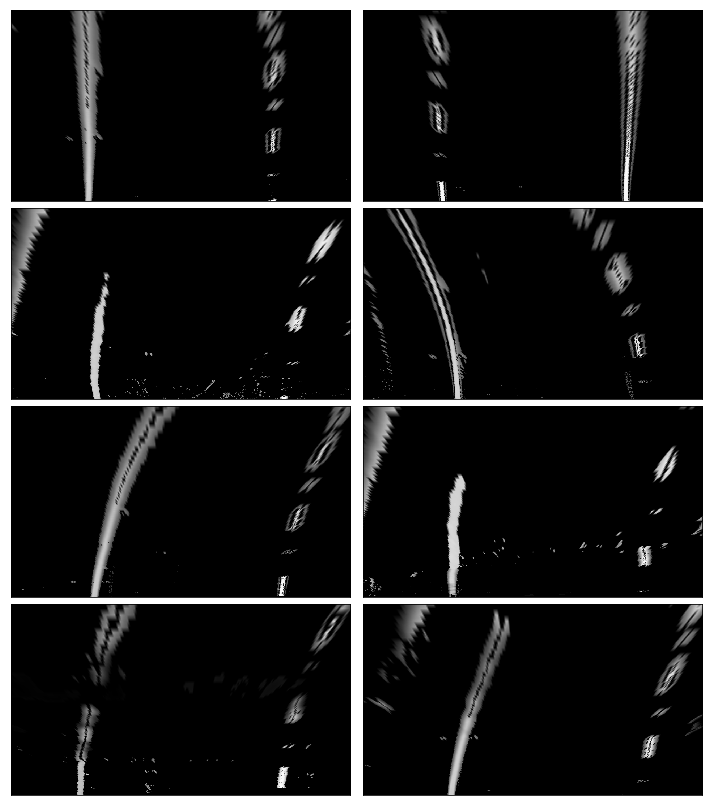

In [25]:
show_images(warped)

### Extract Line Information

In [26]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

In [27]:
def fit_polynomial(binary_warped):
    # Find lane pixels
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    # Find a second order line
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Creates domain of y vertices
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    
    return left_fit, right_fit, ploty

In [28]:
def draw_lane(warped, left_fit, right_fit, ploty):
    # Calculate lane points
    left_fitx = np.poly1d(left_fit)(ploty)
    right_fitx = np.poly1d(right_fit)(ploty)
    
    # Creates a blank image for lines to be drawn
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))
    
    return color_warp

In [29]:
def unwarp(img, Minv):
    img_size = (img.shape[1], img.shape[0])
    unwarp_img = cv2.warpPerspective(img, Minv, img_size)
    
    return unwarp_img

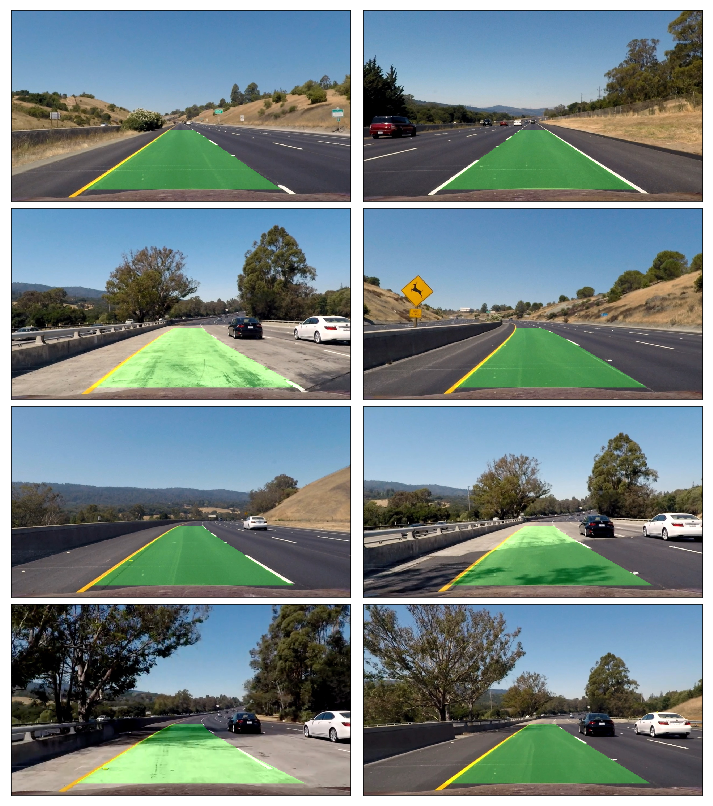

In [30]:
result = []
for undistort, image in zip(test_images, warped):
    left_fit, right_fit, ploty = fit_polynomial(image)
    lane = draw_lane(image, left_fit, right_fit, ploty)
    lane = unwarp(lane, Minv)
    result.append(cv2.addWeighted(undistort, 1, lane, 0.3, 0))
show_images(result)

In [ ]:
def fit_polynomial(binary_warped, xm_per_pix=3.7/700, ym_per_pix=30/720):
    # Find lane pixels
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    # Find a second order line
    left_fit = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Creates domain of y vertices
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    
    return left_fit, right_fit, ploty